In [3]:
%%capture

!pip install -U tensorflow-addons
!pip install patchify

In [13]:
# %reset

In [14]:
!nvidia-smi

Fri May 19 19:19:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    37W / 250W |  15989MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [7]:
hp = {}

hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1
hp["image_size"] = 200
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["num_classes"] = 5
hp["num_channels"] = 3

hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32
hp["lr"] = 1e-4
hp["num_epochs"] = 50
hp["num_classes"] = 5
hp["class_names"] = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [8]:
# config = {}
# config["num_layers"] = 12
# config["hidden_dim"] = 768
# config["mlp_dim"] = 3072
# config["num_heads"] = 12
# config["dropout_rate"] = 0.1
# config["num_patches"] = 256
# config["patch_size"] = 32
# config["num_channels"] = 3
# config["num_classes"] = 5

### Data Preparing

In [17]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

def process_image_label(path):
    """ Reading images """
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0

    """ Preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])

    # patches = np.reshape(patches, (64, 25, 25, 3))
    # for i in range(64):
    #     cv2.imwrite(f"files/{i}.png", patches[i])

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    """ Label """
    class_name = path.split("\\")[1]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels

def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Paths """
    dataset_path = "Dataset/flowers"
    model_path = os.path.join("/kaggle/working/", "model.h5")
    csv_path = os.path.join("/kaggle/working/", "log.csv")

    """ Dataset """
    train_x, valid_x, test_x = load_data(dataset_path)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    train_ds = tf_dataset(train_x, batch=hp["batch_size"])
    valid_ds = tf_dataset(valid_x, batch=hp["batch_size"])

Train: 3455 - Valid: 431 - Test: 431


In [18]:
train_x[0].split("\\")[1]

'dandelion'

In [19]:
# class_count = {'dandelion':0, 'daisy':1, 'sunflower':2, 'tulip':3, 'rose':4}

In [22]:
train_x

['Dataset/flowers\\dandelion\\5725836812_a7d1c5540d_m.jpg',
 'Dataset/flowers\\rose\\8674140377_ae7b0be523.jpg',
 'Dataset/flowers\\daisy\\18582579815_4c6637e9ff_m.jpg',
 'Dataset/flowers\\tulip\\20876954720_62920b4ce8_n.jpg',
 'Dataset/flowers\\daisy\\12348343085_d4c396e5b5_m.jpg',
 'Dataset/flowers\\sunflower\\34692938506_efda47f39a_n.jpg',
 'Dataset/flowers\\rose\\6879112993_5a29208438_n.jpg',
 'Dataset/flowers\\dandelion\\7243174412_d3628e4cc4_m.jpg',
 'Dataset/flowers\\tulip\\14069914547_1fa90bec99_n.jpg',
 'Dataset/flowers\\sunflower\\9246304620_768d1f54d7_n.jpg',
 'Dataset/flowers\\tulip\\14069914647_0296f003c0_n.jpg',
 'Dataset/flowers\\tulip\\8697784345_e75913d220.jpg',
 'Dataset/flowers\\sunflower\\10541580714_ff6b171abd_n.jpg',
 'Dataset/flowers\\dandelion\\5681951567_d3b03bfd2a_m.jpg',
 'Dataset/flowers\\tulip\\6936168062_a31c28b77c_m.jpg',
 'Dataset/flowers\\sunflower\\15495578821_92c6d14252_n.jpg',
 'Dataset/flowers\\tulip\\6989946990_62c639ff16_n.jpg',
 'Dataset/flowers\

In [27]:
def ReturnClassCount(data):
    class_count = {'dandelion':0, 'daisy':0, 'sunflower':0, 'tulip':0, 'rose':0}
    for ind in range(0,len(data)):
        class_count[data[ind].split("\\")[1]] += 1
    return class_count

In [28]:
ReturnClassCount(train_x)

{'dandelion': 850, 'daisy': 629, 'sunflower': 577, 'tulip': 791, 'rose': 608}

In [29]:
ReturnClassCount(valid_x)

{'dandelion': 101, 'daisy': 61, 'sunflower': 84, 'tulip': 93, 'rose': 92}

In [30]:
ReturnClassCount(test_x)

{'dandelion': 101, 'daisy': 74, 'sunflower': 72, 'tulip': 100, 'rose': 84}

**Model Building**

In [57]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model

In [58]:
model = ViT(hp)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 1875)]   0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 64, 768)      1440768     input_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_5 (TFOpLam (None, 64, 768)      0           dense_54[0][0]                   
__________________________________________________________________________________________________
class_token_2 (ClassToken)      (None, 1, 768)       768         tf.__operators__.add_5[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
add_61 (Add)                    (None, 65, 768)      0           dropout_61[0][0]                 
                                                                 add_60[0][0]                     
__________________________________________________________________________________________________
layer_normalization_64 (LayerNo (None, 65, 768)      1536        add_61[0][0]                     
__________________________________________________________________________________________________
multi_head_attention_31 (MultiH (None, 65, 768)      28339968    layer_normalization_64[0][0]     
                                                                 layer_normalization_64[0][0]     
__________________________________________________________________________________________________
add_62 (Add)                    (None, 65, 768)      0           multi_head_attention_31[0][0]    
          

In [51]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
    metrics=["acc"]
)

In [52]:
callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
]

**Start Training**

In [15]:
model.fit(
    train_ds,
    epochs=10,
#     epochs=hp["num_epochs"],
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 2.3711 - acc: 0.2255
Epoch 1: val_loss improved from inf to 1.54257, saving model to /kaggle/working/model.h5
108/108 [==============================] - 169s 1s/step - loss: 2.3711 - acc: 0.2255 - val_loss: 1.5426 - val_acc: 0.2390 - lr: 1.0000e-04
Epoch 2/10
108/108 [==============================] - ETA: 0s - loss: 1.4216 - acc: 0.3685
Epoch 2: val_loss improved from 1.54257 to 1.35699, saving model to /kaggle/working/model.h5
108/108 [==============================] - 130s 1s/step - loss: 1.4216 - acc: 0.3685 - val_loss: 1.3570 - val_acc: 0.4548 - lr: 1.0000e-04
Epoch 3/10
108/108 [==============================] - ETA: 0s - loss: 1.4758 - acc: 0.3479
Epoch 3: val_loss did not improve from 1.35699
108/108 [==============================] - 108s 994ms/step - loss: 1.4758 - acc: 0.3479 - val_loss: 1.5464 - val_acc: 0.2622 - lr: 1.0000e-04
Epoch 4/10
108/108 [==============================] - ETA: 0s - loss: 1.4745 -

**Save Model**

In [ ]:
model.save("/kaggle/working/files/model.h5")

**Evaluate**

In [16]:
# from keras.models import load_model
# model_new = load_model("myModel.h5")

In [127]:
len(test_x)

431

In [17]:
test_ds = tf_dataset(test_x, batch=hp["batch_size"])
model.evaluate(test_ds)

14/14 [==============================] - 9s 565ms/step - loss: 1.1096 - acc: 0.5220


[1.1096326112747192, 0.5220417380332947]

In [119]:
pred = model.predict(test_ds)

14/14 [==============================] - 6s 319ms/step


In [193]:
def GetTestResult(ind):
    Result = []
    max_ind = np.argmax(pred[ind],axis=0)
    condfidence = np.round(pred[ind][max_ind]*100,2)
    class_name = hp["class_names"][max_ind]
    
    Result.append({"Predicted Class" : class_name, "Actual Class":test_x[ind].split("/")[-2], "Confidence": condfidence})
#     return {"Predicted Class" : class_name, "Actual Class":test_x[ind].split("/")[-2], "Confidence": condfidence}
#     return print(" Predicted Class : {}\n Actual Class : {}\n Confidence : {}".format(class_name,test_x[ind].split("/")[-2] ,condfidence))

In [194]:
Result = []
for ind in range(len(test_x)):
    max_ind = np.argmax(pred[ind],axis=0)
    condfidence = np.round(pred[ind][max_ind]*100,2)
    class_name = hp["class_names"][max_ind]
    Result.append({"Predicted Class" : class_name, "Actual Class":test_x[ind].split("/")[-2], "Confidence": condfidence})

In [199]:
import pandas as pd
df = pd.DataFrame(Result)
df['Class_Val_Count']  = None

In [63]:
# df['Class_Val_Count'] = [1 if p == a else 0 for p, a in zip(df['Predicted Class'], df['Actual Class'])]

In [207]:
for ind in range(0,df.shape[0]):
    if df['Predicted Class'].iloc[ind] == df['Actual Class'].iloc[ind]:
        df['Class_Val_Count'].iloc[ind] = 1
    else:
        df['Class_Val_Count'].iloc[ind] = 0

/tmp/ipykernel_31/972266931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Class_Val_Count'].iloc[ind] = 0
/tmp/ipykernel_31/972266931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Class_Val_Count'].iloc[ind] = 1


In [212]:
df['Class_Val_Count'].value_counts()

1    225
0    206
Name: Class_Val_Count, dtype: int64

**Plotting Patch Images**

/tmp/ipykernel_31/3922873893.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


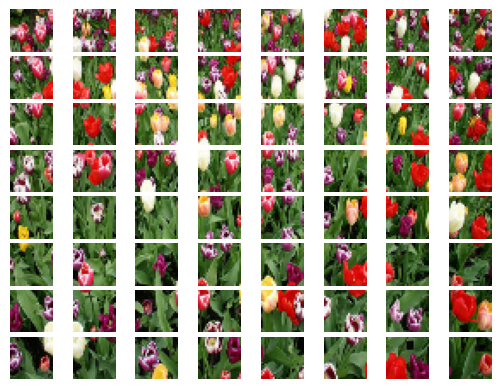

In [104]:
import matplotlib.pyplot as plt

fig, axe = plt.subplots(nrows=8, ncols=8,gridspec_kw={'wspace': 0.1,'hspace':0.1})
ax = axe.ravel()

patches = np.reshape(patches, (64, 25, 25, 3))

for i in range(64):
    image = patches[i]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB
    ax[i].imshow(image_rgb)
    ax[i].axis('off')


plt.tight_layout()
plt.show()

In [62]:
custom_objects = {"ClassToken": ClassToken}
loaded_model = tf.keras.models.load_model("artifacts/model.h5", custom_objects=custom_objects)